<a href="https://www.kaggle.com/code/shaikhabdulrafay03/taylor-swift-data?scriptVersionId=159292807" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Contents
- [Exploring Data](#ED)
- [Standardizing the Features](#sf)
- [Adding new Features](#af)
- [EDA](#EDA)
- [Visualization](#viz)
- [Working in Titles](#wt)
- [PreProcessing](#pp)
- [Modelling](#model)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import nltk
import spacy
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import string
from spacy.lang.en import English
from plotly.subplots import make_subplots

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
stop = stopwords.words('english')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/taylor-swifts-youtube-stats-symphony/taylor_swift_videos.csv


# Exploring data
<a id = 'ED'></a>

In [2]:
df = pd.read_csv(r"/kaggle/input/taylor-swifts-youtube-stats-symphony/taylor_swift_videos.csv")
df

,title,published_at,duration,view_count
0,Taylor Swift - You're Losing Me (From The Vault),2023-11-29T13:00:47Z,PT4M39S,7278886
1,"Rent on demand starting … you guessed it, Dece...",2023-11-27T20:21:45Z,PT1M1S,1050064
2,✨🫶 My name is Taylor and I was born in 1989 🫶✨,2023-10-31T20:08:57Z,PT19S,1196267
3,Taylor Swift - Cruel Summer (LP Giobbi Remix),2023-10-19T00:30:06Z,PT3M19S,696792
4,Taylor Swift - Cruel Summer (Live from Taylor ...,2023-10-19T00:30:25Z,PT3M55S,3437493
...,...,...,...,...
218,First fans with my CMT Award.,2008-06-26T21:55:43Z,PT11S,337626
219,TRL Recap!,2008-06-26T21:15:51Z,PT3M8S,742898
220,Wannabe,2008-06-26T21:02:39Z,PT3M45S,1217405
221,:-),2008-06-26T20:51:09Z,PT34S,805812


In [3]:
print("DataFrame Information:")
print("-" * 30)
print('DF Shape: ' ,df.shape)
print('number of Columns: ' ,len(df.columns))
print('number of Observations: ' ,len(df))
print('Number of values in df: ' , df.count().sum())
print('Total Number of Missing values in df: ' , df.isna().sum().sum())
print('percentage of Missing values : ' ,  "{:.2f}".format(df.isna().sum().sum()/df.count().sum() *100),'%')
print('Total Number of Duplicated records in df : ' , df.duplicated().sum().sum())
print('percentage of Duplicated values : ' ,  "{:.2f}".format(df.duplicated().sum().sum()/df.count().sum() *100),'%')

DataFrame Information:
------------------------------
DF Shape:  (223, 4)
number of Columns:  4
number of Observations:  223
Number of values in df:  892
Total Number of Missing values in df:  0
percentage of Missing values :  0.00 %
Total Number of Duplicated records in df :  0
percentage of Duplicated values :  0.00 %


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         223 non-null    object
 1   published_at  223 non-null    object
 2   duration      223 non-null    object
 3   view_count    223 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 7.1+ KB


# Standardizing the Features
<a id = 'sf'></a>

In [5]:
df['published_at'] = pd.to_datetime(df['published_at'])
df['year'] = df['published_at'].dt.year
df['month'] = df['published_at'].dt.month
df['day'] = df['published_at'].dt.day
df['hour'] = df['published_at'].dt.hour
df['minute'] = df['published_at'].dt.minute
df['day_of_week'] = df['published_at'].dt.dayofweek

df.drop('published_at' ,axis=1 , inplace=True)

In [6]:
from datetime import time
def fromat_duration(value):
    s = value.strip('PT')
    s = s.split('M')
    if len(s) > 1:
        if s[1] != '':
            sec = s[1].strip('S')
        else:
            sec = 0
        min = s[0]
    else:
        min = '0'
        sec = s[0].strip('S')
        
    t = time(minute= int(min) , second=int(sec))  
    return (t.minute * 60) + t.second

df['duration'] = df['duration'].apply(fromat_duration)

    

# Adding new Features
<a id = 'af'></a>

In [7]:
#all taylor swift songs
import requests as req
soups = []
for i in range(1 , 5):
    r = req.get(f"https://www.oldies.com/artist-songs/Taylor-Swift/page_{i}.html")
    print(r.status_code)
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(r.text , "lxml")
    soups.append(soup)

200
200
200
200


In [8]:
name =[]
for soup in soups:
    names = soup.find_all('span' , {'class' : 'PLT'})   
    print(len(names))
    for i in names:  
        name.append(i.string) 

songnames = [song.lower() for song in name]


507
347
36
0


In [9]:
def tour (title  , duration):
    x = ''
    if pd.Series(title).str.contains('tour').bool(): #1
       x =  x +' tour' 
        
    if pd.Series(title).str.contains('behind the scenes|behind-the-scenes').bool(): #2
        x = x + ' BTS'             

    if pd.Series(title).str.contains('short').bool(): #3
        x = x + ' short'
    elif duration < 60:
        x = x + ' short'


    if pd.Series(title).str.contains('remix').bool(): #4
        x = x + ' remix'            

    if pd.Series(title).str.contains('trailer').bool():  #5
        x = x + ' trailer'            
    
    if pd.Series(title).str.contains('featuring').bool(): #6
        x = x + ' featuring'            

    if  any(keyword.lower() in title for keyword in songnames):
        x = x+' music'   #7

    if pd.Series(title).str.contains('live').bool():
        x = x + ' live'  #8

    if pd.Series(title).str.contains('version').bool():
        x = x + ' version'  #9

    if  x == '':
        return 'random'    #10
    return x 


df['title'] = df['title'].apply(str.lower)
df['Tags'] = df['Tags'] = df.apply(lambda row: tour(row['title'], row['duration']), axis=1)



In [10]:
tags = df['Tags'].str.get_dummies(sep=' ')

In [11]:
tags

,BTS,featuring,live,music,random,remix,short,tour,trailer,version
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,1,0,0,0,0
4,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
218,0,0,0,0,0,0,1,0,0,0
219,0,0,0,0,1,0,0,0,0,0
220,0,0,0,0,1,0,0,0,0,0
221,0,0,0,0,0,0,1,0,0,0


In [12]:
df = pd.concat([df , tags] ,axis=1 )
df.drop('Tags' , axis= 1 , inplace =True)

In [13]:
# import os
# path = "C:/Users/minal/Desktop"
# df.to_csv(os.path.join(path, 'taylor_swift_stats_powerbi.csv'), index=False)


# EDA
<a id = 'EDA'></a>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        223 non-null    object
 1   duration     223 non-null    int64 
 2   view_count   223 non-null    int64 
 3   year         223 non-null    int32 
 4   month        223 non-null    int32 
 5   day          223 non-null    int32 
 6   hour         223 non-null    int32 
 7   minute       223 non-null    int32 
 8   day_of_week  223 non-null    int32 
 9   BTS          223 non-null    int64 
 10  featuring    223 non-null    int64 
 11  live         223 non-null    int64 
 12  music        223 non-null    int64 
 13  random       223 non-null    int64 
 14  remix        223 non-null    int64 
 15  short        223 non-null    int64 
 16  tour         223 non-null    int64 
 17  trailer      223 non-null    int64 
 18  version      223 non-null    int64 
dtypes: int32(6), int64(12), objec

In [15]:
df.describe()

,duration,view_count,year,month,day,hour,minute,day_of_week,BTS,featuring,live,music,random,remix,short,tour,trailer,version
count,223.000000,2.230000e+02,223.000000,223.000000,223.000000,223.000000,223.00000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,173.605381,4.245633e+06,2014.766816,7.650224,15.623318,13.901345,25.70852,2.313901,0.143498,0.008969,0.062780,0.565022,0.174888,0.062780,0.322870,0.107623,0.031390,0.044843
std,254.861005,1.401885e+07,4.817327,3.528978,8.416618,7.214172,19.86101,1.588283,0.351368,0.094489,0.243113,0.496869,0.380726,0.243113,0.468625,0.310601,0.174762,0.207425
min,7.000000,4.781500e+04,2008.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.500000,2.871150e+05,2011.000000,4.000000,8.500000,6.000000,6.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,122.000000,8.571970e+05,2013.000000,8.000000,16.000000,16.000000,25.00000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,223.500000,2.224946e+06,2019.000000,11.000000,23.000000,20.000000,44.50000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2553.000000,1.259220e+08,2023.000000,12.000000,31.000000,23.000000,59.00000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df.describe(include='object')

,title
count,223
unique,223
top,taylor swift - you're losing me (from the vault)
freq,1


In [17]:
df[df['duration'] < 60]

,title,duration,view_count,year,month,day,hour,minute,day_of_week,BTS,featuring,live,music,random,remix,short,tour,trailer,version
2,✨🫶 my name is taylor and i was born in 1989 🫶✨,19,1196267,2023,10,31,20,8,1,0,0,0,0,0,0,1,0,0,0
5,the eras tour concert film is now officially c...,31,1338900,2023,9,26,11,58,1,0,0,0,0,0,0,1,1,0,0
6,thank you for making these reveals so much cha...,29,857197,2023,9,20,22,13,2,0,0,0,0,0,0,1,0,0,0
8,pre order 1989 (taylor’s version) now on my si...,16,1489197,2023,8,10,6,26,3,0,0,0,0,0,0,1,0,0,1
9,summer forecast: cruel. 😎,26,2505814,2023,7,21,18,56,4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,new conference table.,31,1318531,2010,3,12,16,10,4,0,0,0,0,0,0,1,0,0,0
207,retainers.,59,3195952,2008,11,17,21,25,0,0,0,0,0,0,0,1,0,0,0
217,my band has bad private plane manners.,25,837052,2008,6,26,21,58,3,0,0,0,0,0,0,1,0,0,0
218,first fans with my cmt award.,11,337626,2008,6,26,21,55,3,0,0,0,0,0,0,1,0,0,0


In [18]:
df[df['view_count'] > 10000000]

,title,duration,view_count,year,month,day,hour,minute,day_of_week,BTS,featuring,live,music,random,remix,short,tour,trailer,version
7,taylor swift | the eras tour concert film offi...,90,11545908,2023,8,31,12,17,3,0,0,0,0,0,0,0,1,1,0
11,taylor swift - snow on the beach (feat. more l...,230,11267965,2023,5,26,4,0,4,0,0,0,0,1,0,0,0,0,0
23,"it’s me, benjamin 🐱 joining the #tsantiherocha...",16,50506505,2022,11,11,17,4,4,0,0,0,0,0,0,1,0,0,0
29,"it’s me, 👋 sharing all the problems. join the ...",16,57972784,2022,11,4,14,53,4,0,0,0,0,0,0,1,0,0,0
31,total surprise 😉 share yours with #tsantihero...,16,78028885,2022,11,1,12,31,1,0,0,0,1,0,0,1,0,0,0
33,🫣 join my #tsantiherochallenge and share your ...,16,125922041,2022,10,21,12,10,4,0,0,0,1,0,0,1,0,0,0
34,😺 join my #tsantiherochallenge and share your ...,16,105500781,2022,10,21,12,10,4,0,0,0,1,0,0,1,0,0,0
51,taylor swift - lover remix feat. shawn mendes ...,222,39230523,2019,11,13,12,27,2,0,0,0,1,0,1,0,0,0,0
57,taylor swift - lover's lounge (live),2023,15966196,2019,8,22,21,47,3,0,0,1,1,0,0,0,0,0,0
58,taylor swift - livestream announcement (8/22/1...,40,13821516,2019,8,15,18,6,3,0,0,1,1,0,0,1,0,0,0


In [19]:
tags['music'].value_counts()

music
1    126
0     97
Name: count, dtype: int64

# Visualization
<a id = 'viz'></a>

In [20]:
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

line = px.line(df, x = 'year_month', y = 'view_count', title='Line Chart')
line.show()
df.drop('year_month' , axis = 1 , inplace = True)

In [21]:
temp = df.sort_values(by='duration' , ascending= True)
px.line(temp , x = 'duration' , y = 'view_count' ,title = 'Line Chart' ) 


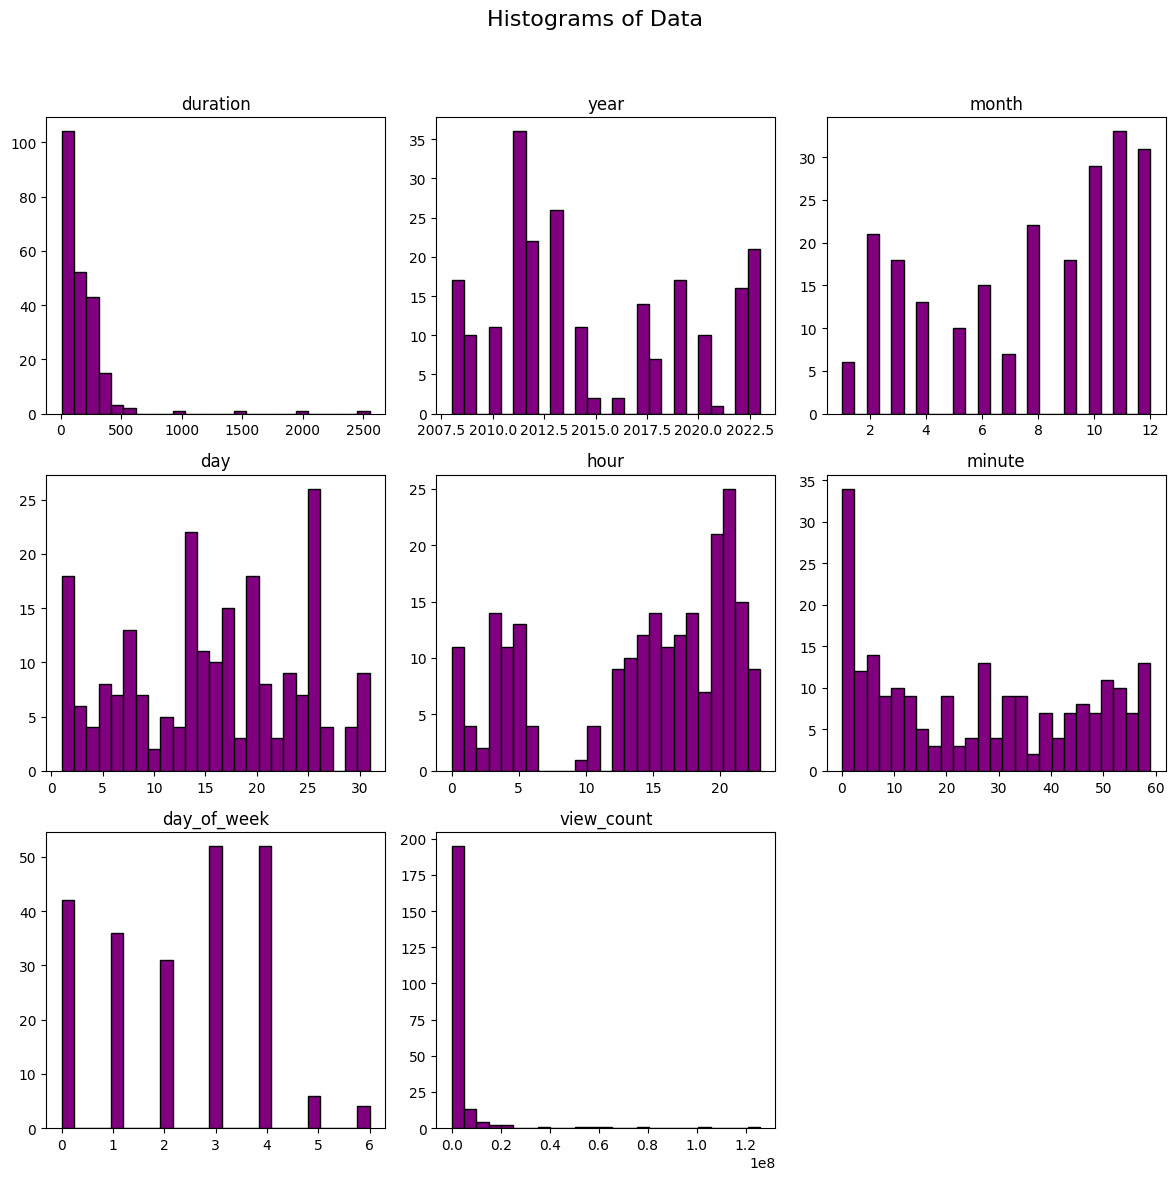

In [22]:
df[['duration' ,'year', 'month', 'day', 'hour','minute', 'day_of_week', 'view_count'] ].hist(
         bins = 25, color='purple', edgecolor='black', grid=False , figsize = (12, 12) )

plt.suptitle('Histograms of Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for spine in plt.gca().spines.values():
    spine.set_visible(False)


plt.show()

In [23]:
fig = make_subplots(rows=4, cols=3, subplot_titles=['BTS','version','featuring','music','remix','tour','trailer' , 'short', 'random','live' ])

fig.add_trace(go.Histogram(x=df['BTS'], marker_color='green'), row=1, col=1)
fig.add_trace(go.Histogram(x=df['version'], marker_color='gold'), row=1, col=2)
fig.add_trace(go.Histogram(x=df['featuring'], marker_color='purple'), row=1, col=3)
fig.add_trace(go.Histogram(x=df['music'], marker_color='red'), row=2, col=1)
fig.add_trace(go.Histogram(x=df['remix'], marker_color='lightblue'), row=2, col=2)
fig.add_trace(go.Histogram(x=df['tour'], marker_color='black'), row=2, col=3)
fig.add_trace(go.Histogram(x=df['trailer'], marker_color='pink'), row=3, col=1)
fig.add_trace(go.Histogram(x=df['short'], marker_color='gray'), row=3, col=2)
fig.add_trace(go.Histogram(x=df['random'], marker_color='brown'), row=3, col=3)
fig.add_trace(go.Histogram(x=df['live'], marker_color='darkblue'), row=4, col=1)

fig.update_layout(height=900, width=1000, title_text="Histogram Subplots")
fig.show()

# Working in Titles
<a id = 'wt'></a>

In [24]:
port_stem = PorterStemmer()
def stemming(title):
    stemmed_title = title.lower()
    stemmed_title = stemmed_title.split()
    stemmed_title = [port_stem.stem(word) for word in stemmed_title if not word in stopwords.words('english')]
    stemmed_title = ' '.join(stemmed_title)
    return stemmed_title

df['title'] = df['title'].apply(stemming)

In [25]:
df['title']

0                       taylor swift - lose (from vault)
1             rent demand start … guess it, decemb 13 🫶💋
2                            ✨🫶 name taylor born 1989 🫶✨
3          taylor swift - cruel summer (lp giobbi remix)
4      taylor swift - cruel summer (live taylor swift...
                             ...                        
218                                 first fan cmt award.
219                                           trl recap!
220                                               wannab
221                                                  :-)
222                                                 said
Name: title, Length: 223, dtype: object

In [26]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd

nltk.download('punkt')

titles = df['title']

def tokenize(title):
    tokens = word_tokenize(title)
    return tokens

tokenized_titles = titles.apply(tokenize)

model = Word2Vec(sentences=tokenized_titles, vector_size=100, window=5, min_count=1, workers=4)

def get_embedding(title):
    tokens = tokenize(title)
    title_embedding = sum([model.wv[token] for token in tokens]) / len(tokens)
    return title_embedding

embeddings = titles.apply(get_embedding)

embeddings_array = pd.DataFrame(embeddings.tolist()).to_numpy()

embedding_columns = [f'embedding_{i+1}' for i in range(embeddings_array.shape[1])]
df[embedding_columns] = pd.DataFrame(embeddings_array)

df.drop('title', axis=1, inplace=True)
print(df)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     duration  view_count  year  month  day  hour  minute  day_of_week  BTS  \
0         279     7278886  2023     11   29    13       0            2    0   
1          61     1050064  2023     11   27    20      21            0    0   
2          19     1196267  2023     10   31    20       8            1    0   
3         199      696792  2023     10   19     0      30            3    0   
4         235     3437493  2023     10   19     0      30            3    0   
..        ...         ...   ...    ...  ...   ...     ...          ...  ...   
218        11      337626  2008      6   26    21      55            3    0   
219       188      742898  2008      6   26    21      15            3    0   
220       225     1217405  2008      6   26    21       2            3    0   
221        34      805812  2008      6   26    20      51            3    0   
222       262  

/tmp/ipykernel_18/2103873247.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_18/2103873247.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_18/2103873247.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_18/2103873247.py:28: PerformanceWarning:

In [27]:
df

,duration,view_count,year,month,day,hour,minute,day_of_week,BTS,featuring,...,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100
0,279,7278886,2023,11,29,13,0,2,0,0,...,0.003240,0.000354,0.000805,-0.005421,0.008041,0.001314,0.004447,-0.000467,0.000716,-0.000851
1,61,1050064,2023,11,27,20,21,0,0,0,...,0.000190,-0.000534,-0.002821,-0.001939,0.002701,0.001376,-0.002712,0.001438,-0.002511,-0.000972
2,19,1196267,2023,10,31,20,8,1,0,0,...,-0.000447,0.001978,-0.000536,0.002425,-0.001641,-0.003386,0.000537,-0.000358,0.001676,0.003211
3,199,696792,2023,10,19,0,30,3,0,0,...,-0.001433,0.001027,0.000680,-0.002758,0.002354,-0.001706,0.001303,-0.002001,0.003092,0.000082
4,235,3437493,2023,10,19,0,30,3,0,0,...,0.001748,0.000653,0.002234,-0.002173,0.003334,0.001143,0.001287,-0.001152,0.000089,0.001282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,11,337626,2008,6,26,21,55,3,0,0,...,0.000063,0.001625,0.002603,0.004963,0.005085,-0.000726,-0.001143,0.000346,-0.001843,0.003341
219,188,742898,2008,6,26,21,15,3,0,0,...,0.001141,0.001060,-0.001509,-0.000417,0.000199,0.001281,-0.002838,0.002832,-0.004693,0.001402
220,225,1217405,2008,6,26,21,2,3,0,0,...,-0.001956,-0.003234,0.001960,0.006051,0.006080,-0.005385,-0.001699,-0.005304,0.005130,-0.005674
221,34,805812,2008,6,26,20,51,3,0,0,...,-0.003544,0.003218,0.003613,-0.002814,0.012119,0.005652,0.005091,-0.000553,0.004324,-0.006097


# PreProcessing
<a id = 'pp'></a>

In [28]:
df[['view_count','year','month' ,'day','hour','minute','day_of_week']].skew()

view_count     6.162094
year           0.415554
month         -0.417552
day           -0.096974
hour          -0.615859
minute         0.196596
day_of_week   -0.023003
dtype: float64

In [29]:
for i in ['view_count','year','month' ,'day','hour','minute','day_of_week']:
    if df[i].dtype != object :
        if df[i].skew() > 0.5: 
            df[i] = df[i].apply(lambda x: np.log(x))

In [30]:
df[['view_count','year','month' ,'day','hour','minute','day_of_week']].skew()

view_count     0.662748
year           0.415554
month         -0.417552
day           -0.096974
hour          -0.615859
minute         0.196596
day_of_week   -0.023003
dtype: float64

In [31]:
# df.drop(['BTS','version','featuring','remix','tour','trailer','random','live'] , axis =1, inplace=True)
y = df.pop('view_count')

In [32]:
df.columns

Index(['duration', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week',
       'BTS', 'featuring', 'live',
       ...
       'embedding_91', 'embedding_92', 'embedding_93', 'embedding_94',
       'embedding_95', 'embedding_96', 'embedding_97', 'embedding_98',
       'embedding_99', 'embedding_100'],
      dtype='object', length=117)

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
df_without_embed = df[['duration', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week',
       'music', 'short' , 'BTS','version','featuring','remix','tour','trailer','random','live']]
kbest = SelectKBest(f_classif, k=10)
x = kbest.fit_transform(df_without_embed, y)

print('Selected features:',  df_without_embed.columns[kbest.get_support()].tolist())

Selected features: ['music', 'short', 'BTS', 'version', 'featuring', 'remix', 'tour', 'trailer', 'random', 'live']


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning:

invalid value encountered in divide



In [34]:
df.drop(['duration', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week'],  axis = 1, inplace = True)


In [35]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler() 
df = scaler.fit_transform(df)
df

array([[ 0.        ,  0.        ,  0.        , ...,  0.30155409,
         0.04461183, -0.5598844 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.00163328,
        -1.12653233, -0.61741453],
       [ 0.        ,  0.        ,  0.        , ...,  0.34186074,
         0.39283448,  1.37512769],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.47542216,
         1.64652592, -2.85696772],
       [ 0.        ,  0.        ,  0.        , ...,  0.27019353,
         1.35399379, -3.05879813],
       [ 0.        ,  0.        ,  0.        , ..., -1.68153397,
         1.20311146, -2.15943642]])

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(df, y, test_size=0.2, random_state=42)
print("Training shape:", xtrain.shape, ytrain.shape)
print("Testing shape:", xtest.shape, ytest.shape)



Training shape: (178, 110) (178,)
Testing shape: (45, 110) (45,)


# Modelling
<a id= 'model'></a>

In [37]:
# without grid search
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
svr = SVR()
knn = KNeighborsRegressor()
nn = MLPRegressor()
xgb = XGBRegressor() 

models = [linear , ridge ,lasso, dt ,rf,gb,svr ,knn ,nn ,xgb ]

train_score = []
test_score = []

for M in models:
    M.fit(xtrain,ytrain)
    train_score.append(M.score(xtrain , ytrain))
    test_score.append(M.score(xtest,ytest))
    
dict = {
    'Name' : ['linear' , 'ridge','lasso', 'dt' ,'rf','gb','svr' ,'knn' ,'nn' ,'xgb' ],
    'Train_Scores' : train_score,
    'Test_Scores' : test_score,
 }

dd = pd.DataFrame(dict)
dd 

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



,Name,Train_Scores,Test_Scores
0,linear,0.810599,-0.912143
1,ridge,0.798162,-0.179032
2,lasso,0.000000,-0.035246
3,dt,1.000000,-0.357131
4,rf,0.915334,0.294851
5,gb,0.995160,0.321689
6,svr,0.688679,0.386220
7,knn,0.586915,0.199513
8,nn,0.202135,-6.834268
9,xgb,1.000000,0.184273


In [38]:
#with gridsearch

from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import make_scorer, r2_score


param_grids = {
    'linear': {},
    'ridge': {'alpha': [0.1, 1.0, 10.0]},
    'lasso': {'alpha': [0.1, 1.0, 10.0]},
    'dt': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'rf': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]},
    'gb': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'svr': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    'knn': {'n_neighbors': [3, 5, 7]},
    'nn': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]},
    'xgb': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

best_models = {}
best_train_scores = []
best_test_scores = []

for model_name, model in zip(dd['Name'], models):
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, scoring=make_scorer(r2_score), cv=5, n_jobs=-1)
    grid_search.fit(xtrain, ytrain)
    
    best_model = grid_search.best_estimator_
    best_train_score = grid_search.best_score_
    best_test_score = r2_score(ytest, best_model.predict(xtest))
    
    best_models[model_name] = best_model
    best_train_scores.append(best_train_score)
    best_test_scores.append(best_test_score)

result_dict = {
    'Name': dd['Name'],
    'Best_Train_Score': best_train_scores,
    'Best_Test_Score': best_test_scores
}

result_df = pd.DataFrame(result_dict)
result_df


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

,Name,Best_Train_Score,Best_Test_Score
0,linear,-2.653669,-0.912143
1,ridge,0.030366,0.310532
2,lasso,0.239149,0.112558
3,dt,-0.084572,-0.486751
4,rf,0.413353,0.211006
5,gb,0.402597,0.325348
6,svr,0.476169,0.400263
7,knn,0.338288,0.199513
8,nn,-4.616379,-4.969524
9,xgb,0.326554,0.208605
